In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### Load Train Data

In [2]:
df = pd.read_csv('datingData_training.txt', sep='\s+', header=None)
df.head(3)

,0,1,2,3
0,40920,8.326976,0.953952,largeDoses
1,14488,7.153469,1.673904,smallDoses
2,26052,1.441871,0.805124,didntLike


In [3]:
df.columns = ['fly_miles', 'video_game', 'ice_cream', 'class']
df.head(3)

,fly_miles,video_game,ice_cream,class
0,40920,8.326976,0.953952,largeDoses
1,14488,7.153469,1.673904,smallDoses
2,26052,1.441871,0.805124,didntLike


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fly_miles   600 non-null    int64  
 1   video_game  600 non-null    float64
 2   ice_cream   600 non-null    float64
 3   class       600 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 18.9+ KB


In [5]:
df.isnull().values.any()

False

In [6]:
df['class'].unique()

array(['largeDoses', 'smallDoses', 'didntLike'], dtype=object)

In [7]:
label = {'largeDoses': 2, 'smallDoses': 1, 'didntLike': 0}
df['class'].replace(label, inplace=True)

In [8]:
df.head(3)

,fly_miles,video_game,ice_cream,class
0,40920,8.326976,0.953952,2
1,14488,7.153469,1.673904,1
2,26052,1.441871,0.805124,0


In [9]:
y_train = df['class']               
X_train = df.drop(['class'], axis=1)

In [10]:
print(f'Training data features: {X_train.shape} \nTraining data labels: {y_train.shape}')

Training data features: (600, 3) 
Training data labels: (600,)


### Load Test Data

In [11]:
df_ = pd.read_csv('datingData_test.txt', sep='\s+', header=None)
df_.head(3)

,0,1,2,3
0,9916,2.695935,1.512111,smallDoses
1,38889,3.356646,0.324230,didntLike
2,39075,14.677836,0.793183,largeDoses


In [12]:
df_.columns = ['fly_miles', 'video_game', 'ice_cream', 'class']
df_.head(3)

,fly_miles,video_game,ice_cream,class
0,9916,2.695935,1.512111,smallDoses
1,38889,3.356646,0.324230,didntLike
2,39075,14.677836,0.793183,largeDoses


In [13]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fly_miles   400 non-null    int64  
 1   video_game  400 non-null    float64
 2   ice_cream   400 non-null    float64
 3   class       400 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 12.6+ KB


In [14]:
df_.isnull().values.any()

False

In [15]:
df_['class'].replace(label, inplace=True)

In [16]:
df_.head(3)

,fly_miles,video_game,ice_cream,class
0,9916,2.695935,1.512111,1
1,38889,3.356646,0.324230,0
2,39075,14.677836,0.793183,2


In [17]:
y_test = df_['class']               
X_test = df_.drop(['class'], axis=1)

In [18]:
print(f'Testing data features: {X_test.shape} \nTesting data labels: {y_test.shape}')

Testing data features: (400, 3) 
Testing data labels: (400,)


# Overview
- In each classifier, we will be finding the best hyper-paramaters using simple KFold as the `cv` parameter to evaluate scores by cross-validation 
- When cross-validating, we only use the **training** data in the training phase
- After training the model, we evaluate the model performance on the **testing** set

In [19]:
df['class'].value_counts()

class
0    220
2    200
1    180
Name: count, dtype: int64

- We have a nearly equal distribution of classes, so we will use KFold in the cross-validation procedure
- In KFold, the training data is divided into k-equal folds; where k-1 fold is used for training and one fold is left out for validation
- `cross_val_score` is used to obtain the f-score for each test fold; the varying parameters that achieve the max score is then used for testing the model

# 1. K-Nearest Neighbours Classifier

In [20]:
# scale the data
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [87]:
# build and train model with scaled data
def knn(n, w):
    clf = KNeighborsClassifier(n_neighbors=n, weights=w)
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)
    
    print('Metrics:')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    f_measure = f1_score(y_test, y_pred, average='weighted')
    print(f'\tAccuracy: {accuracy} \n\tPrecision: {precision} \n\tF-Measure: {f_measure}')
    
    return accuracy, precision, f_measure

In [88]:
knn(3, 'uniform')

Metrics:
	Accuracy: 0.9525 
	Precision: 0.9527608941861719 
	F-Measure: 0.9524102470488013


(0.9525, 0.9527608941861719, 0.9524102470488013)

### Find the best  `n_neighbors` and `weights`:
-  Find the best neighbor(s) and compare them to their cross validation score 
- We are using both 'uniform' and 'distance' weights to describe how each k performs
- Uniform weighs each k equally, and distance weighs each k by the inverse of their distance

In [89]:
score_list1 = []
k_list = list(range(1,16))
cv = KFold(n_splits=10, random_state=1, shuffle=True)

for w in ['uniform', 'distance']:
    for k in k_list:
        clf = KNeighborsClassifier(n_neighbors=k, weights=w)
        score1 = cross_val_score(clf, X_train_s, y_train, cv=cv, scoring='f1_weighted')
        score_list1.append([w, k, np.mean(score1)])

In [90]:
#score_list
params1 = max(score_list1, key=lambda x: x[2])
print(f'Optimal parameters: {params1}')

Optimal parameters: ['distance', 8, 0.9500673781830635]


In [91]:
# filter score list
uniform = list(filter(lambda x: 'uniform' in x, score_list1))
f1 = [x[2] for x in uniform]

distance = list(filter(lambda x: 'distance' in x, score_list1))
f2 = [x[2] for x in distance]

Text(0.02, 0.5, 'F-Measure')

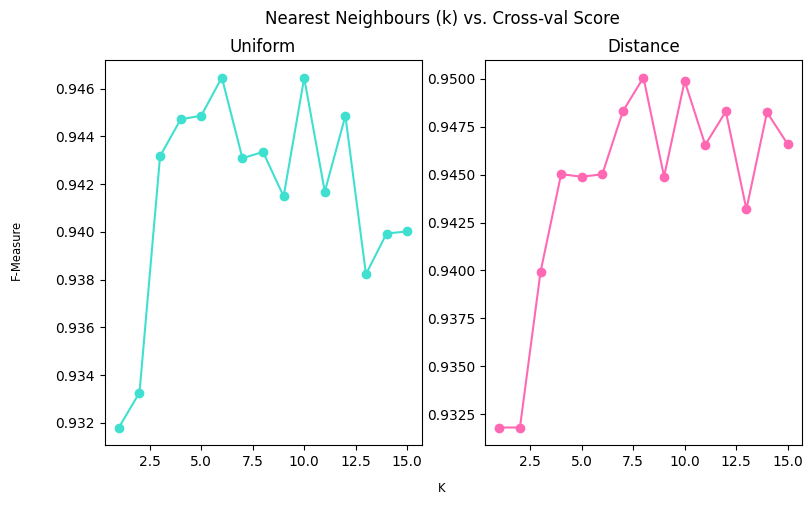

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
ax[0].plot(k_list, f1, 'o-', color='turquoise')
ax[1].plot(k_list, f2, 'o-', color='hotpink')
 
ax[0].set_title('Uniform')
ax[1].set_title('Distance')

fig.suptitle('Nearest Neighbours (k) vs. Cross-val Score')
fig.supxlabel('K', fontsize = 'small')
fig.supylabel('F-Measure', fontsize = 'small')

**Figure 1.** K-Nearest Neighbours (k: from 1 to 15) and the average f-measure using cross_val_score 
- As we increase k, f-measure generally increases.
- Distance weighting assigns higher weights to closer training examples; it may perform better as it can reduce the influence of outliers.

### Apply hyper-parameters:

In [93]:
m1 = knn(8, 'distance')
m1

Metrics:
	Accuracy: 0.96 
	Precision: 0.9600016129032258 
	F-Measure: 0.9599622531939604


(0.96, 0.9600016129032258, 0.9599622531939604)

# 2. Support Vector Classifier

In [94]:
def svm(c, k):
    clf = SVC(C=c, kernel=k)
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)
    
    print('Metrics:')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    f_measure = f1_score(y_test, y_pred, average='weighted')
    print(f'\tAccuracy: {accuracy} \n\tPrecision: {precision} \n\tF-Measure: {f_measure}')
    
    return accuracy, precision, f_measure

In [95]:
svm(1, 'linear')

Metrics:
	Accuracy: 0.9125 
	Precision: 0.913576057789531 
	F-Measure: 0.912040076965672


(0.9125, 0.913576057789531, 0.912040076965672)

### Find the best `C` and `kernel`:
- To find the best C with varying kernel types, we will be using a similar strategy as above with knn

In [96]:
score_list2 = []
C_list = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
cv = KFold(n_splits=10, random_state=1, shuffle=True)
#cv=10
for popcorn in kernels:
    for c in C_list:
        clf = SVC(C=c, kernel=popcorn)
        score2 = cross_val_score(clf, X_train_s, y_train, cv=cv, scoring='f1_weighted')
        score_list2.append([popcorn, c, np.mean(score2)])

In [97]:
#score_list
params2 = max(score_list2, key=lambda x: x[2])
print(f'Optimal parameters: {params2}')

Optimal parameters: ['rbf', 0.8, 0.9549000943585421]


In [98]:
lin = list(filter(lambda x: 'linear' in x, score_list2))
f1 = [x[2] for x in lin]

poly = list(filter(lambda x: 'poly' in x, score_list2))
f2 = [x[2] for x in poly]

rbf = list(filter(lambda x: 'rbf' in x, score_list2))
f3 = [x[2] for x in rbf]

sig = list(filter(lambda x: 'sigmoid' in x, score_list2))
f4 = [x[2] for x in sig]

Text(0.02, 0.5, 'F-Measure')

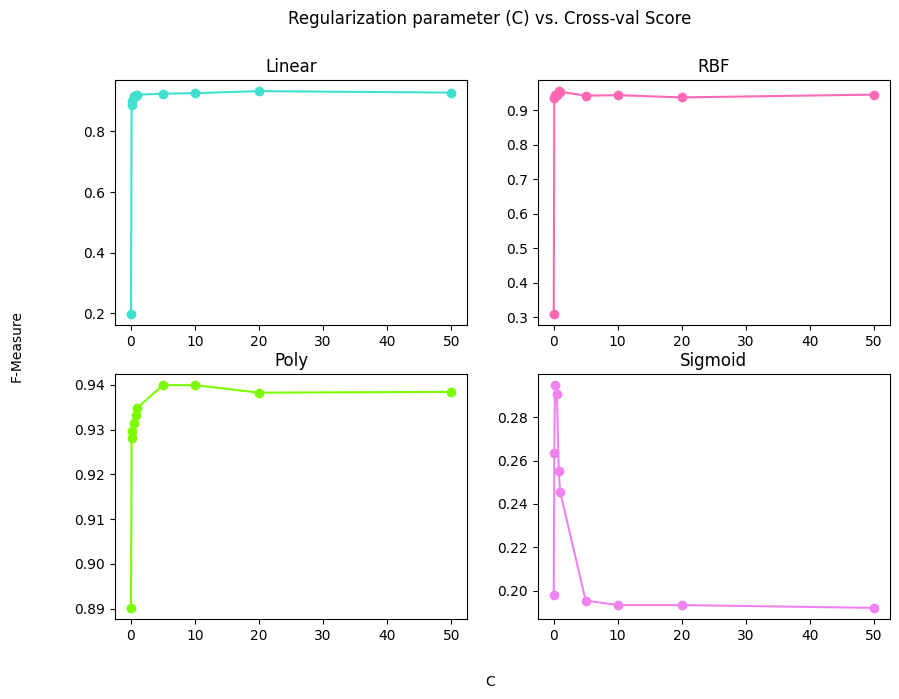

In [99]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

ax[0,0].plot(C_list, f1, 'o-', color='turquoise')
ax[0,0].set_title('Linear')

ax[1,0].plot(C_list, f2, 'o-', color='lawngreen')
ax[1,0].set_title('Poly')

ax[0,1].plot(C_list, f3, 'o-', color='hotpink')
ax[0,1].set_title('RBF')

ax[1,1].plot(C_list, f4, 'o-', color='violet')
ax[1,1].set_title('Sigmoid')

fig.suptitle('Regularization parameter (C) vs. Cross-val Score')
fig.supxlabel('C', fontsize = 'medium')
fig.supylabel('F-Measure', fontsize = 'medium')

**Figure 2.** SVM with varying C and the average f-measure using cross_val_score 
- The 'rbf' kernel performs best; this may imply that the decision boundaries between the classes are non-linear.
- Smaller C has larger margin of the hyperplane with more tolerance of error and yields the highest f-measure.

### Apply hyper-parameters:

In [100]:
m2 = svm(0.8, 'rbf')
m2

Metrics:
	Accuracy: 0.95 
	Precision: 0.9506872258771929 
	F-Measure: 0.9499340030197351


(0.95, 0.9506872258771929, 0.9499340030197351)

# 3. Decision Tree Classifier

In [101]:
def decisionTree(depth, criteria):
    clf = tree.DecisionTreeClassifier(max_depth=depth, criterion=criteria)
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)
    
    print('Metrics:')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    f_measure = f1_score(y_test, y_pred, average='weighted')
    print(f'\tAccuracy: {accuracy} \n\tPrecision: {precision} \n\tF-Measure: {f_measure}')
    
    return accuracy, precision, f_measure

In [102]:
decisionTree(3, 'gini')

Metrics:
	Accuracy: 0.95 
	Precision: 0.9511670128706419 
	F-Measure: 0.9498819902559785


(0.95, 0.9511670128706419, 0.9498819902559785)

### Find the best `max_depth` and `criterion`:
- Looking for the best max depth using both 'gini' and 'entropy' as criteria

In [103]:
score_list3 = []
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
cv = KFold(n_splits=10, random_state=1, shuffle=True)

for criteria in ['gini', 'entropy']:
    for depth in maxdepths:
        clf = tree.DecisionTreeClassifier(max_depth=depth, criterion=criteria)
        score3 = cross_val_score(clf, X_train_s, y_train, cv=cv, scoring='f1_weighted')
        score_list3.append([criteria, depth, np.mean(score3)])

In [104]:
#score_list
params3 = max(score_list3, key=lambda x: x[2])
print(f'Optimal parameters: {params3}')

Optimal parameters: ['entropy', 4, 0.9533367184625121]


In [105]:
gini = list(filter(lambda x: 'gini' in x, score_list3))
f1 = [x[2] for x in gini]

entropy = list(filter(lambda x: 'entropy' in x, score_list3))
f2 = [x[2] for x in entropy]

Text(0.02, 0.5, 'F-Measure')

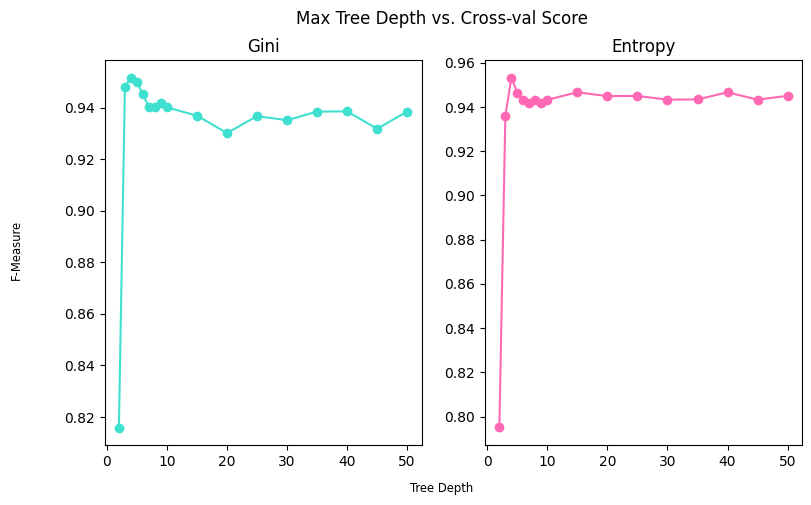

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
ax[0].plot(maxdepths, f1, 'o-', color='turquoise')
ax[1].plot(maxdepths, f2, 'o-', color='hotpink')
 
ax[0].set_title('Gini')
ax[1].set_title('Entropy')

fig.suptitle('Max Tree Depth vs. Cross-val Score')
fig.supxlabel('Tree Depth', fontsize = 'small')
fig.supylabel('F-Measure', fontsize = 'small')

**Figure 3.** Decision Tree with varying tree depth and the average f-measure using cross_val_score 
- Gini and Entropy follow the same pattern of decreasing f-measure with increasing tree depth; however, Entropy produces a slightly higher average f-measure.

### Apply hyper-parameters:

In [107]:
m3 = decisionTree(4, 'entropy')
m3

Metrics:
	Accuracy: 0.975 
	Precision: 0.9753295001291042 
	F-Measure: 0.9749774564110427


(0.975, 0.9753295001291042, 0.9749774564110427)

# Conclusions

In [108]:
print('1. K-NN after optimization:')
print(f'\n\tAccuracy: {m1[0]} \n\tPrecision: {m1[1]} \n\tF-Measure: {m1[2]}')
print(f'\n\tHyper-parameters = {params1}')

print('\n2. SVM after optimization:')
print(f'\n\tAccuracy: {m2[0]} \n\tPrecision: {m2[1]} \n\tF-Measure: {m2[2]}')
print(f'\n\tHyper-parameters = {params2}')

print('\n3. Decision Tree after optimization:')
print(f'\n\tAccuracy: {m3[0]} \n\tPrecision: {m3[1]} \n\tF-Measure: {m3[2]}')
print(f'\n\tHyper-parameters = {params3}')

1. K-NN after optimization:

	Accuracy: 0.96 
	Precision: 0.9600016129032258 
	F-Measure: 0.9599622531939604

	Hyper-parameters = ['distance', 8, 0.9500673781830635]

2. SVM after optimization:

	Accuracy: 0.95 
	Precision: 0.9506872258771929 
	F-Measure: 0.9499340030197351

	Hyper-parameters = ['rbf', 0.8, 0.9549000943585421]

3. Decision Tree after optimization:

	Accuracy: 0.975 
	Precision: 0.9753295001291042 
	F-Measure: 0.9749774564110427

	Hyper-parameters = ['entropy', 4, 0.9533367184625121]


Feature scaling was used for each model: 
- k-NN and SVM requires this so that features with significant magnitude do not dominate other attributes
- DecisionTree does not require this, however, consistency matters

The best model for classification using the optimal hyper-parameters is the **Decision Tree**, then K-NN and SVM (in descending order). In Decision Tree, we ran cross-validation on the f-measure metric with varying impurity (i.e., gini, entropy) and tree depth. In both measures of impurity, we can see that an increased tree depth decreases the f-measure. After tuning the hyper-parameters, the optimal parameters are `max_depth=4` and `criterion='entropy'`

In all three models, the results of the hyper-parameter tuning showed an increase in all tested metrics: accuracy, precision, and f-measure.